# def

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 300
import math
import datetime as dt
from tableone import TableOne, load_dataset
import itertools
import random
import scipy.stats as stats

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
df_type = pd.read_csv("df_mixAK_fea4_C3_eicu.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))

df_type_filt["groupHPD"].value_counts()

# Define the recovery mode
First, assess the condition of the kidneys at each time, and then consider the time to comprehensively determine the recovery mode

Determination of kidney condition:
- When the urine volume does not meet the definition of KDIGO AKI, it is determined as complete recovery C(complete recovery).
- When creatinine does not meet the definition of KDIGO AKI, it is determined as complete recovery C(complete recovery).
- Otherwise, it indicates that P (partial) has not been restored yet.
- Complete recovery is determined when the creatinine level is within 30% of the baseline creatinine

Recovery mode determination
- quick recovery of QR, recovery within 3 days
- slow recovery SR, recovery within 7 days (slow recovery)
- worse
- Recovery refers to the situation where the number of consecutive points "not meeting the AKI definition" is greater than the number of points "meeting the AKI definition".

# Define of kidney condition

## Obtain data-aki stage,aki_stage_uo，aki_stage_cre

In [3]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_sk_first_and_max_stage.csv")
df_time = df_time[["stay_id","first_aki_onset","aki_endtime","aki_endstage"]]
df_time["los_saaki"] = (df_time["aki_endtime"] - df_time["first_aki_onset"])/1
df_time.head(2)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stay_id,first_aki_onset,aki_endtime,aki_endstage,los_saaki
0,243208.0,14,48,0,34.0
1,243765.0,21,159,0,138.0


In [ ]:
## Obtain the maximum stages defined by urine volume or creatinine at each time point
df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_kdigo_stages_based_time.csv")
df_stage = df_stage[df_stage['time']>=0]
df_stage = df_stage[df_stage["stay_id"].isin(all_lst)]
filt_id_lst = df_stage[df_stage["time"]>=2].stay_id.unique()
df_stage = df_stage[df_stage["stay_id"].isin(filt_id_lst)]
df_stage.head(3)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stay_id,time,aki_stage_uo,aki_stage_creat,aki_stage
30,243208.0,0,3.0,0.0,3.0
31,243208.0,1,3.0,0.0,3.0
32,243208.0,2,2.0,0.0,2.0


In [ ]:
## Obtain the change process
ss = "aki_stage_creat"  
print(ss)
tmp_df = pd.DataFrame(columns=["stay_id", "state_crea_start", "state_crea_max", "state_crea_end"])
for i,j in df_stage.groupby(["stay_id"]):
    sstart = j[j["time"]==0][ss].tolist()[0]
    smax = sorted(j[ss].tolist()[1:-1])[-1]
    send = j[ss].tolist()[-1] 
    tmp_df.loc[len(tmp_df)] = [i[0], sstart, smax, send]
df = pd.merge(df_stage, tmp_df, how="inner",on="stay_id")

ss = "aki_stage_uo"  
print(ss)
tmp_df = pd.DataFrame(columns=["stay_id", "state_uo_start", "state_uo_max", "state_uo_end"])
for i,j in df_stage.groupby(["stay_id"]):
    sstart = j[j["time"]==0][ss].tolist()[0]
    smax = sorted(j[ss].tolist()[1:-1])[-1]
    send = j[ss].tolist()[-1] 
    tmp_df.loc[len(tmp_df)] = [i[0], sstart, smax, send]
df = pd.merge(df, tmp_df, how="inner",on="stay_id")

ss = "aki_stage" 
print(ss)
tmp_df = pd.DataFrame(columns=["stay_id", "state_start", "state_max", "state_end"])
for i,j in df_stage.groupby(["stay_id"]):
    sstart = j[j["time"]==0][ss].tolist()[0]
    smax = sorted(j[ss].tolist()[1:-1])[-1]
    send = j[ss].tolist()[-1] 
    tmp_df.loc[len(tmp_df)] = [i[0], sstart, smax, send]
df = pd.merge(df, tmp_df, how="inner",on="stay_id")

#Replace the final status of the AKI disease course
df = df.drop(["state_end"],axis=1)
tmp_df = df_time[["stay_id","aki_endstage"]]
tmp_df.columns = ["stay_id","state_end"]
df = pd.merge(df, tmp_df,how="left",on="stay_id")
df.head(2)

aki_stage_creat


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aki_stage_uo
aki_stage


,stay_id,time,aki_stage_uo,aki_stage_creat,aki_stage,state_crea_start,state_crea_max,state_crea_end,state_uo_start,state_uo_max,state_uo_end,state_start,state_max,state_end
0,243208.0,0,3.0,0.0,3.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,3.0,0
1,243208.0,1,3.0,0.0,3.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,3.0,0


## Define the change process by getting better/getting worse/remaining unchanged
- The first point: The state when time = 1
- The second point: The point with the largest number of stages throughout the entire process
- The third point: A state where there are more than five points from the end

In [6]:
df_cut = df[['stay_id','time','state_crea_start', 'state_crea_max', 'state_crea_end', 'state_uo_start',
             'state_uo_max', 'state_uo_end','state_start','state_max', 'state_end']].drop_duplicates()

#################
t0 = "state_crea_start"
tm = "state_crea_max"
t1 = "state_crea_end"
tc = "state_crea_change"
# B
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]==0), tc] = "CB"
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]==0), tc] = "CB"

# W
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[t1] >= df_cut[tm]),tc] = "W"
# S
df_cut.loc[ (df_cut[tm] == df_cut[t0]) &  (df_cut[t1] == df_cut[tm]),tc] = "S"

#################
t0 = "state_uo_start"
tm = "state_uo_max"
t1 = "state_uo_end"
tc = "state_uo_change"
# B
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]==0), tc] = "CB"
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]==0), tc] = "CB"

# W
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[t1] >= df_cut[tm]),tc] = "W"
# S
df_cut.loc[ (df_cut[tm] == df_cut[t0]) &  (df_cut[t1] == df_cut[tm]),tc] = "S"

#################
t0 = "state_start"
tm = "state_max"
t1 = "state_end"
tc = "state_change"
# B
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]==0), tc] = "CB"
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]==0), tc] = "CB"

# W
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[t1] >= df_cut[tm]),tc] = "W"
# S
df_cut.loc[ (df_cut[tm] == df_cut[t0]) &  (df_cut[t1] == df_cut[tm]),tc] = "S"
df_cut = df_cut[['stay_id','state_crea_change','state_uo_change', 'state_change']].drop_duplicates()


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def determine_state_change(row):
    if pd.isna(row['state_change']):
        if pd.notna(row['state_crea_change']) and pd.notna(row['state_uo_change']):
            if row['state_crea_change'] == row['state_uo_change']:
                return row['state_crea_change']
            else:
                return 'S'
        else:
            return 'S'
    else:
        return row['state_change']

df_cut['state_change'] = df_cut.apply(determine_state_change, axis=1)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# df_cut1 = pd.merge(df_cut,df_type_filt, how="inner",on="stay_id")
# df_type_filt_count = pd.DataFrame(df_type_filt.groupHPD.value_counts()).reset_index()
# df_type_filt_count.columns = ["groupHPD","count"]

# fea = "state_change" 
# print(fea)
# ##
# tmp_df = pd.DataFrame(df_cut1[df_cut1["groupHPD"]==3][[fea]].value_counts()).reset_index()
# tmp_df["groupHPD"]=3
# df_out = tmp_df

# tmp_df = pd.DataFrame(df_cut1[df_cut1["groupHPD"]==2][[fea]].value_counts()).reset_index()
# tmp_df["groupHPD"]=2
# df_out = pd.concat([df_out,tmp_df],axis=0)

# tmp_df = pd.DataFrame(df_cut1[df_cut1["groupHPD"]==1][[fea]].value_counts()).reset_index()
# tmp_df["groupHPD"]=1
# df_out = pd.concat([df_out,tmp_df],axis=0)
# df_out = df_out.sort_values(["groupHPD"])
# df_out = pd.merge(df_out,df_type_filt_count, how="inner",on="groupHPD")
# df_out["percent"] = round(df_out[0] /df_out["count"] *100,2)
# df_out.columns = ['type', 0, 'groupHPD', 'count', 'percent']
# df_out.head(2)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# df_out["dataset"] = "eICU"
# df_out.columns = ['type', 'count', 'groupHPD', 'count_all', 'percent', 'dataset']
# df_out.to_csv("./result/eICU_renal_recovery_1.csv",index=False)
# df_out.head()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# The distribution of AKI grades at the time of diagnosis in the three groups
# y1 = df_out[df_out["type"]=="S"]["percent"].tolist()
# y2 = df_out[df_out["type"]=="CB"]["percent"].tolist()
# y3 = df_out[df_out["type"]=="PB"]["percent"].tolist()
# y4 = df_out[df_out["type"]=="W"]["percent"].tolist()

# x = ["C1","C2","C3"]
# y1 = np.array(y1)
# y2 = np.array(y2)
# y3 = np.array(y3)
# y4 = np.array(y4)

# plt.figure(figsize=(12, 6))
# plt.bar(x,y1,width=0.4,label='steady',color='#ffffb3',edgecolor='grey')
# plt.bar(x,y2,width=0.4,bottom=y1,label='full recovery',color='#74c476',edgecolor='grey')
# plt.bar(x,y3,width=0.4,bottom=y1+y2,label='partial recovery',color='#bcbddc',edgecolor='grey')
# plt.bar(x,y4,width=0.4,bottom=y1+y2+y3,label='worsen',color='#fd8d3c',edgecolor='grey')

# plt.yticks(np.arange(0,110,20),[f'{i}%' for i in range(0,120,20)])
# plt.grid(axis='y',alpha=0.5,ls='--')

# plt.legend(frameon=False,bbox_to_anchor=(1.01,1))
# plt.title(fea)
# plt.tight_layout()
# plt.show()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Recovery Mode determination
- Recovery within 3 days/Recovery within 7 days/No recovery within 7 days

In [11]:
df_ = df_cut[["stay_id","state_change"]].drop_duplicates()
df_ = pd.merge(df_,df_time[["stay_id","los_saaki"]],how="inner",on="stay_id")

df_.loc[(df_["state_change"]=="CB") & (df_["los_saaki"]<=48),"stayid_state"] = "Rapidly revered AKI"
df_.loc[(df_["state_change"]=="CB") & (df_["los_saaki"]>48),"stayid_state"] = "Persistent AKI with full renal recovery"
df_.loc[(df_["state_change"]=="PB"),"stayid_state"] = "Persistent AKI with partial renal recovery"
df_.loc[(df_["state_change"]=="W"),"stayid_state"] = "Persistent AKI with worsening renal function"
df_.loc[(df_["state_change"]=="S"),"stayid_state"] = "Persistent AKI with worsening renal function" #"Persistent AKI with steady renal function"
df_stayid_s = df_
df_.head(1)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stay_id,state_change,los_saaki,stayid_state
0,243208.0,CB,34.0,Rapidly revered AKI


In [12]:
df_count_all = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
df_count_all.columns = ["groupHPD", "count_all"]

tmp_df = pd.merge(df_stayid_s,df_type_filt, how="inner",on="stay_id")
tmp_df = tmp_df.groupby(["groupHPD","stayid_state"]).agg({"stay_id":"count"}).reset_index()
tmp_df = pd.merge(tmp_df,df_count_all, how="inner",on="groupHPD")
tmp_df["percent(%)"] = round(tmp_df["stay_id"]/tmp_df["count_all"]*100,2)
tmp_df.sort_values(["groupHPD",'stayid_state'])

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,stayid_state,stay_id,count_all,percent(%)
0,1,Persistent AKI with full renal recovery,144,423,34.04
1,1,Persistent AKI with partial renal recovery,80,423,18.91
2,1,Persistent AKI with worsening renal function,79,423,18.68
3,1,Rapidly revered AKI,117,423,27.66
4,2,Persistent AKI with full renal recovery,272,869,31.30
5,2,Persistent AKI with partial renal recovery,83,869,9.55
6,2,Persistent AKI with worsening renal function,179,869,20.60
7,2,Rapidly revered AKI,316,869,36.36
8,3,Persistent AKI with full renal recovery,6,125,4.80
9,3,Persistent AKI with partial renal recovery,40,125,32.00


In [13]:
tmp_df["dataset"] = "eICU"
tmp_df.to_csv("./result/eICU_renal_recovery_2.csv",index=False)
tmp_df

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,stayid_state,stay_id,count_all,percent(%),dataset
0,1,Persistent AKI with full renal recovery,144,423,34.04,eICU
1,1,Persistent AKI with partial renal recovery,80,423,18.91,eICU
2,1,Persistent AKI with worsening renal function,79,423,18.68,eICU
3,1,Rapidly revered AKI,117,423,27.66,eICU
4,2,Persistent AKI with full renal recovery,272,869,31.30,eICU
5,2,Persistent AKI with partial renal recovery,83,869,9.55,eICU
6,2,Persistent AKI with worsening renal function,179,869,20.60,eICU
7,2,Rapidly revered AKI,316,869,36.36,eICU
8,3,Persistent AKI with full renal recovery,6,125,4.80,eICU
9,3,Persistent AKI with partial renal recovery,40,125,32.00,eICU


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


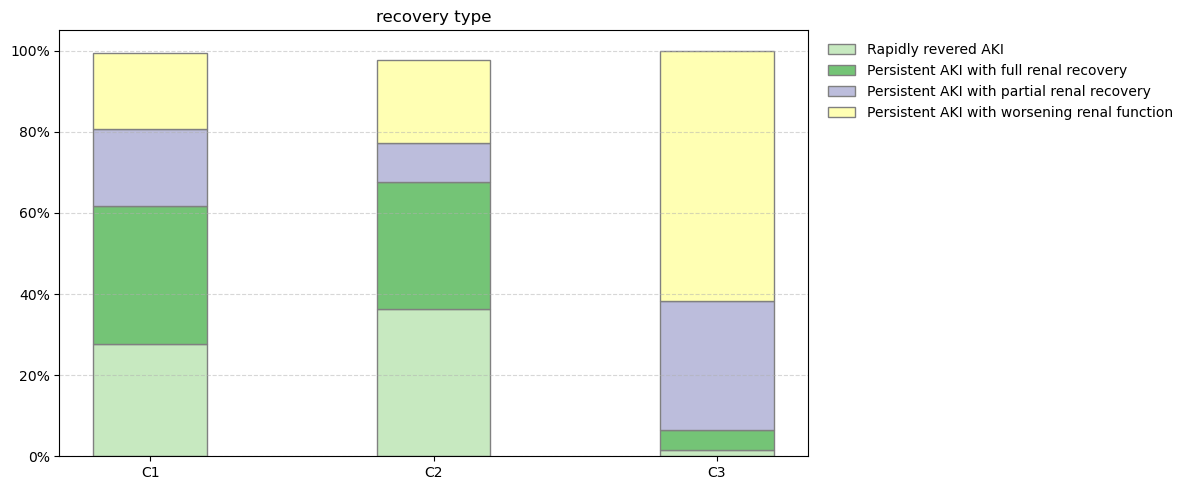

In [ ]:
#The distribution of AKI grades at the time of diagnosis in the three groups
y1 = tmp_df[tmp_df["stayid_state"]=="Rapidly revered AKI"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y2 = tmp_df[tmp_df["stayid_state"]=="Persistent AKI with full renal recovery"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y3 = tmp_df[tmp_df["stayid_state"]=="Persistent AKI with partial renal recovery"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y4 = tmp_df[tmp_df["stayid_state"]=="Persistent AKI with worsening renal function"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
#y5 = tmp_df[tmp_df["stayid_state"]=="Persistent AKI with worsening renal function"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()

x = ["C1","C2","C3"]
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)

plt.figure(figsize=(12, 5)) 
plt.bar(x,y1,width=0.4,label='Rapidly revered AKI',color='#c7e9c0',edgecolor='grey')
plt.bar(x,y2,width=0.4,bottom=y1,label='Persistent AKI with full renal recovery',color='#74c476',edgecolor='grey')
plt.bar(x,y3,width=0.4,bottom=y1+y2,label='Persistent AKI with partial renal recovery',color='#bcbddc',edgecolor='grey')
plt.bar(x,y4,width=0.4,bottom=y1+y2+y3,label='Persistent AKI with worsening renal function',color='#ffffb3',edgecolor='grey')
#plt.bar(x,y5,width=0.4,bottom=y1+y2+y3+y4,label='Persistent AKI with worsening renal function',color='#fd8d3c',edgecolor='grey')

plt.yticks(np.arange(0,120,20),[f'{i}%' for i in range(0,120,20)])
plt.grid(axis='y',alpha=0.5,ls='--')

plt.legend(frameon=False,bbox_to_anchor=(1.01,1))
plt.title("recovery type")
plt.tight_layout()
plt.show()

In [15]:
# tmp_df = df_stayid_s[["stay_id","stayid_state"]]

# df_admit = pd.read_csv("sk_survival.csv")
# df_admit = df_admit.loc[:,["stay_id","groupHPD", "mortality_28d"]]
# df_admit = pd.merge(df_admit,tmp_df,how="inner",on="stay_id")

# df_admit = df_admit.groupby(["groupHPD","stayid_state"]).agg({"mortality_28d":"sum","stay_id":"count"}).reset_index()
# df_admit["mortality_percent"] = (df_admit["mortality_28d"]/df_admit["stay_id"])*100
# df_admit

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Recovery mode determination - Degree

In [16]:
df_ = df_cut[["stay_id","state_change"]].drop_duplicates()
df_ = pd.merge(df_,df_time[["stay_id","los_saaki"]],how="inner",on="stay_id")

df_.loc[(df_["state_change"]=="CB"),"stayid_state"] = "Full renal recovery"
df_.loc[(df_["state_change"]=="PB"),"stayid_state"] = "Partial renal recovery"
df_.loc[(df_["state_change"]=="W"),"stayid_state"] = "Worsening renal function"
df_.loc[(df_["state_change"]=="S"),"stayid_state"] = "Worsening renal function" #"Persistent AKI with steady renal function"
df_stayid_s = df_
df_stayid_s.head(1)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stay_id,state_change,los_saaki,stayid_state
0,243208.0,CB,34.0,Full renal recovery


In [ ]:

# df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_sk_first_and_max_stage.csv")
# df_stage = pd.merge(df_stage,df_type_filt,how="inner",on="stay_id")

# stage3_lst = df_stage[(df_stage["first_aki_stage"].isin([2,3])) & (df_stage["groupHPD"].isin([1,2]))]["stay_id"]
# print(len(stage3_lst),len(stage3_lst)/df_stage.shape[0])

# tmp_df = pd.DataFrame(df_stayid_s[df_stayid_s["stay_id"].isin(stage3_lst)].stayid_state.value_counts())
# tmp_df["stage23"] = len(stage3_lst)
# tmp_df["percent"] = tmp_df["stayid_state"]/tmp_df["stage23"]
# tmp_df

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
tmp_df = pd.merge(df_stayid_s,df_type_filt, how="inner",on="stay_id")

df_count_all = pd.DataFrame(tmp_df["groupHPD"].value_counts()).reset_index()
df_count_all.columns = ["groupHPD", "count_all"]

tmp_df = tmp_df.groupby(["groupHPD","stayid_state"]).agg({"stay_id":"count"}).reset_index()
tmp_df = pd.merge(tmp_df,df_count_all, how="inner",on="groupHPD")
tmp_df["percent(%)"] = round(tmp_df["stay_id"]/tmp_df["count_all"]*100,2)
tmp_df.sort_values(["groupHPD",'stayid_state'])

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,stayid_state,stay_id,count_all,percent(%)
0,1,Full renal recovery,261,420,62.14
1,1,Partial renal recovery,80,420,19.05
2,1,Worsening renal function,79,420,18.81
3,2,Full renal recovery,588,850,69.18
4,2,Partial renal recovery,83,850,9.76
5,2,Worsening renal function,179,850,21.06
6,3,Full renal recovery,8,125,6.40
7,3,Partial renal recovery,40,125,32.00
8,3,Worsening renal function,77,125,61.60


In [19]:
tmp_df["dataset"] = "eICU"
tmp_df.to_csv("./result/eICU_renal_recovery_extent.csv",index=False)
tmp_df

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,stayid_state,stay_id,count_all,percent(%),dataset
0,1,Full renal recovery,261,420,62.14,eICU
1,1,Partial renal recovery,80,420,19.05,eICU
2,1,Worsening renal function,79,420,18.81,eICU
3,2,Full renal recovery,588,850,69.18,eICU
4,2,Partial renal recovery,83,850,9.76,eICU
5,2,Worsening renal function,179,850,21.06,eICU
6,3,Full renal recovery,8,125,6.40,eICU
7,3,Partial renal recovery,40,125,32.00,eICU
8,3,Worsening renal function,77,125,61.60,eICU


# Recovery mode determination - Time

In [20]:
df_ = df_cut[["stay_id","state_change"]].drop_duplicates()
df_ = pd.merge(df_,df_time[["stay_id","los_saaki"]],how="inner",on="stay_id")

df_.loc[(df_["state_change"]=="CB") & (df_["los_saaki"]<=48),"stayid_state"] = "Transient AKI"
df_.loc[(df_["state_change"]=="CB") & (df_["los_saaki"]>48),"stayid_state"] = "Persistent AKI"
df_.loc[(df_["state_change"]=="PB"),"stayid_state"] = "Persistent AKI"
df_.loc[(df_["state_change"]=="W"),"stayid_state"] = "Persistent AKI"
df_.loc[(df_["state_change"]=="S"),"stayid_state"] = "Persistent AKI" #"Persistent AKI with steady renal function"
df_stayid_s = df_
df_stayid_s.head(1)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stay_id,state_change,los_saaki,stayid_state
0,243208.0,CB,34.0,Transient AKI


In [21]:
tmp_df = pd.merge(df_stayid_s,df_type_filt, how="inner",on="stay_id")

df_count_all = pd.DataFrame(tmp_df["groupHPD"].value_counts()).reset_index()
df_count_all.columns = ["groupHPD", "count_all"]

tmp_df = tmp_df.groupby(["groupHPD","stayid_state"]).agg({"stay_id":"count"}).reset_index()
tmp_df = pd.merge(tmp_df,df_count_all, how="inner",on="groupHPD")
tmp_df["percent(%)"] = round(tmp_df["stay_id"]/tmp_df["count_all"]*100,2)
tmp_df.sort_values(["groupHPD",'stayid_state'])

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,stayid_state,stay_id,count_all,percent(%)
0,1,Persistent AKI,303,420,72.14
1,1,Transient AKI,117,420,27.86
2,2,Persistent AKI,534,850,62.82
3,2,Transient AKI,316,850,37.18
4,3,Persistent AKI,123,125,98.40
5,3,Transient AKI,2,125,1.60


In [22]:
tmp_df["dataset"] = "eICU"
tmp_df.to_csv("./result/eICU_renal_recovery_time.csv",index=False)
tmp_df

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,stayid_state,stay_id,count_all,percent(%),dataset
0,1,Persistent AKI,303,420,72.14,eICU
1,1,Transient AKI,117,420,27.86,eICU
2,2,Persistent AKI,534,850,62.82,eICU
3,2,Transient AKI,316,850,37.18,eICU
4,3,Persistent AKI,123,125,98.40,eICU
5,3,Transient AKI,2,125,1.60,eICU
